In [107]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")
import numpy as np

df = pd.read_csv('../data/UNdata_Total_amount_of_municipal_waste_collected_worldwide_1990-2016.csv', encoding = "ISO-8859-1")
df.head()

,Country or Area,Year,Value,Value Footnotes,Unit
0,Albania,2003,1057.000000,NaN,1000 tonnes
1,Algeria,2015,5182.157227,NaN,1000 tonnes
2,Algeria,2014,4816.811035,NaN,1000 tonnes
3,Andorra,2015,42.070114,NaN,1000 tonnes
4,Andorra,2014,41.141983,NaN,1000 tonnes


In [108]:
df_grouped = df.groupby('Year', as_index = True).mean()
df_grouped

,Value
Year,
1990,17788.783472
1991,73578.282715
1992,61454.094141
1993,75019.624512
1994,75806.875000
...,...
2012,12305.064716
2013,12609.519737
2014,12203.853731


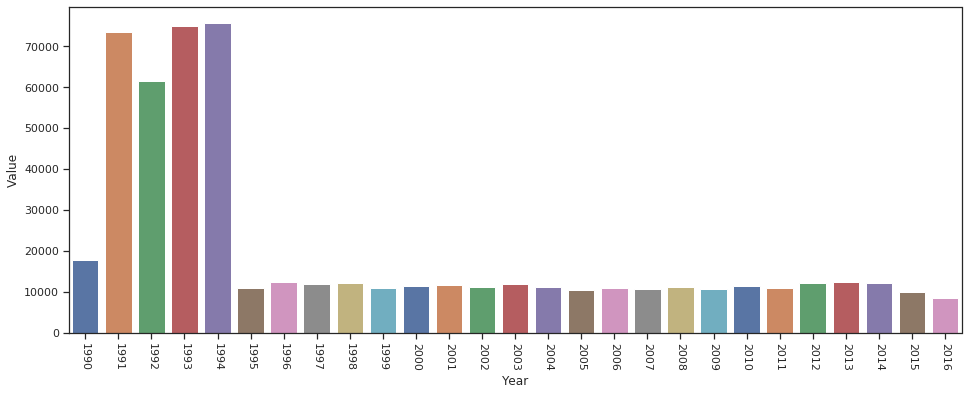

In [109]:
plt.figure(figsize=(16,6))
sns.barplot(x=df_grouped.index, y=df_grouped['Value'], palette="deep")
plt.xticks(rotation=-90);

I intended to use this dataset to give a general overview of the amount of garbage collected over the years, so I grouped them by year and created a barchart. At first I used the sum of all garbage of all years, but I soon found out that this would not work out due to the fact that not every country had reported their amount of garbage for every year. The alternative seemed to be using the mean vanlue, but this gave outliers in the years 1991-1994. Browsing through the dataset, I found out that this was due to the fact that in these four years only 4 or 5 countries had data, and the values of these countries were very high.

For a moment I thought that I could solve this by just leaving these four years of outliers out, but I soon realized that the effect that produced the outliers was also influencing the other years, so their values might just seem in line by coincidence. In order to rule this effect out, I had to look at the amount of garbage collected per capita. The problem is that I needed the amount of inhabitants per country, but also per year, so let's load a dataset containing that data:

In [110]:
wp = pd.read_csv('../data/world_population_altered.csv', delimiter=';')
wp.head()

,Country_Name,Country_Code,Indicator_Name,Indicator_Code,y1960,y1961,y1962,y1963,y1964,y1965,...,y2010,y2011,y2012,y2013,y2014,y2015,y2016,y2017,y2018,y2019
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,...,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,NaN


The two dataframes need to be joined in order to calculate the amount of waste per capita from data in both dataframes. Before they can be merged, I will unpivot (or melt) the world population dataframe:

In [111]:
columns = list(wp)
columns = columns[columns.index('y1990'):columns.index('y2016')+1] # List of all columns we need: 1990 - 2016
wp_melted = pd.melt(wp, id_vars=['Country_Name'], value_vars=columns, var_name='Year', value_name='population') #unpivot (melt) wp
wp_melted['Year'] = wp_melted['Year'].str[1:] # Remove y prefix from years
wp_melted['Year'] = pd.to_numeric(wp_melted['Year']) # convert Year to Int64
wp_melted #preview wp_melted

,Country_Name,Year,population
0,Aruba,1990,62149.0
1,Afghanistan,1990,12412308.0
2,Angola,1990,11848386.0
3,Albania,1990,3286542.0
4,Andorra,1990,54509.0
...,...,...,...
7123,Kosovo,2016,1816200.0
7124,Yemen,2016,27168210.0
7125,South Africa,2016,56203654.0
7126,Zambia,2016,16363507.0


The population values are displayed in "thousand inhabitants", so let's multiply those values by 1000. WHile I'm at it, I will also convert the df['Value']  to kilograms, as we will calculate the municipalwaste per capita later and it will presumably not be much more than 1000 kilograms per person.

In [112]:
wp_melted['population'] = wp_melted['population'] * 1000
wp_melted

,Country_Name,Year,population
0,Aruba,1990,6.214900e+07
1,Afghanistan,1990,1.241231e+10
2,Angola,1990,1.184839e+10
3,Albania,1990,3.286542e+09
4,Andorra,1990,5.450900e+07
...,...,...,...
7123,Kosovo,2016,1.816200e+09
7124,Yemen,2016,2.716821e+10
7125,South Africa,2016,5.620365e+10
7126,Zambia,2016,1.636351e+10


In [113]:
df['Value'] = df['Value'] * 1000000
df['Unit'] = 'kg'
df.head()

,Country or Area,Year,Value,Value Footnotes,Unit
0,Albania,2003,1.057000e+09,NaN,kg
1,Algeria,2015,5.182157e+09,NaN,kg
2,Algeria,2014,4.816811e+09,NaN,kg
3,Andorra,2015,4.207011e+07,NaN,kg
4,Andorra,2014,4.114198e+07,NaN,kg


I merge both data frames, making sure to do an inner join and that the years and countries match:

In [114]:
df_pop = pd.merge(df, wp_melted, how='inner', left_on=['Year', 'Country or Area'], right_on=['Year', 'Country_Name'])
df_pop #preview df_pop

,Country or Area,Year,Value,Value Footnotes,Unit,Country_Name,population
0,Albania,2003,1.057000e+09,NaN,kg,Albania,3.039616e+09
1,Algeria,2015,5.182157e+09,NaN,kg,Algeria,3.972802e+10
2,Algeria,2014,4.816811e+09,NaN,kg,Algeria,3.892369e+10
3,Andorra,2015,4.207011e+07,NaN,kg,Andorra,7.801100e+07
4,Andorra,2014,4.114198e+07,NaN,kg,Andorra,7.921300e+07
...,...,...,...,...,...,...,...
1545,Zimbabwe,2008,1.010000e+08,55,kg,Zimbabwe,1.237955e+10
1546,Zimbabwe,2007,6.230000e+07,55,kg,Zimbabwe,1.225592e+10
1547,Zimbabwe,2005,7.498000e+07,55,kg,Zimbabwe,1.207670e+10
1548,Zimbabwe,2004,1.198000e+08,55,kg,Zimbabwe,1.201991e+10


Now that the population is in my municipal waste data frame, the waste (value) per capita can be calculated by a simple devision:

In [115]:
df_pop['value_per_capita'] = df_pop['Value'] / df_pop['population']
df_pop

,Country or Area,Year,Value,Value Footnotes,Unit,Country_Name,population,value_per_capita
0,Albania,2003,1.057000e+09,NaN,kg,Albania,3.039616e+09,0.347741
1,Algeria,2015,5.182157e+09,NaN,kg,Algeria,3.972802e+10,0.130441
2,Algeria,2014,4.816811e+09,NaN,kg,Algeria,3.892369e+10,0.123750
3,Andorra,2015,4.207011e+07,NaN,kg,Andorra,7.801100e+07,0.539284
4,Andorra,2014,4.114198e+07,NaN,kg,Andorra,7.921300e+07,0.519384
...,...,...,...,...,...,...,...,...
1545,Zimbabwe,2008,1.010000e+08,55,kg,Zimbabwe,1.237955e+10,0.008159
1546,Zimbabwe,2007,6.230000e+07,55,kg,Zimbabwe,1.225592e+10,0.005083
1547,Zimbabwe,2005,7.498000e+07,55,kg,Zimbabwe,1.207670e+10,0.006209
1548,Zimbabwe,2004,1.198000e+08,55,kg,Zimbabwe,1.201991e+10,0.009967


Just like above, we group this data per year and take it's mean value (as not every year has the same amount of countries to get data from, cumulating the values would show a distorted picture):

In [116]:
df_pop_grouped = df_pop.groupby('Year', as_index = True).mean()
df_pop_grouped

,Value,population,value_per_capita
Year,,,
1990,1.778878e+10,4.063115e+10,0.417377
1991,7.357828e+10,1.264276e+11,0.545377
1992,6.145409e+10,1.058122e+11,0.546928
1993,7.501962e+10,1.293188e+11,0.502310
1994,7.580688e+10,1.307212e+11,0.494883
...,...,...,...
2012,1.230506e+10,4.128191e+10,0.478388
2013,1.324295e+10,4.211425e+10,1.258164
2014,1.220385e+10,4.595583e+10,0.444873


And then it's time to redraw the barchart:

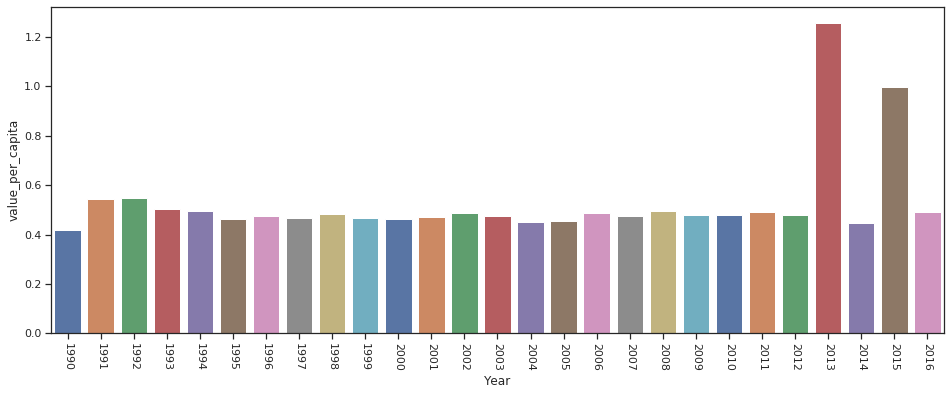

In [117]:
plt.figure(figsize=(16,6))
sns.barplot(x=df_pop_grouped.index, y=df_pop_grouped['value_per_capita'], palette="deep")
plt.xticks(rotation=-90);